In [2]:
# Import modules
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import stats

# Read in dataset
df = pd.read_csv("bank_data.csv")

# Print the first few rows of the DataFrame
df.head()

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
0,2030,194,263.540,Level 0 Recovery,19,Male
1,1150,486,416.090,Level 0 Recovery,25,Female
2,380,527,429.350,Level 0 Recovery,27,Male
3,1838,536,296.990,Level 0 Recovery,25,Male
4,1995,541,346.385,Level 0 Recovery,34,Male


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


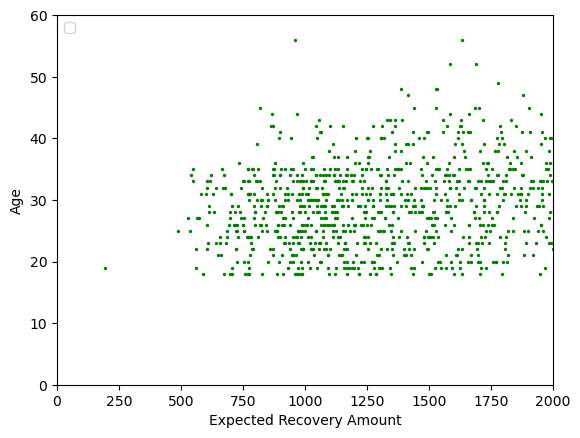

In [3]:
# Create scatter plot of Age vs. Expected Recovery Amount 
plt.scatter(x=df['expected_recovery_amount'], y=df['age'], c="g", s=2)
plt.xlim(0, 2000)
plt.ylim(0, 60)
plt.xlabel("Expected Recovery Amount")
plt.ylabel("Age")
plt.legend(loc=2)

In [ ]:
# There is no major jump in the customer age just above and below the $1000 threshold.

In [4]:
# Compute average age just below and above the threshold for Level 1 recovery
era_900_1100 = df.loc[(df['expected_recovery_amount']<1100) & 
                      (df['expected_recovery_amount']>=900)]

# Perform Kruskal-Wallis test to determine if the difference in customer age just above and below threshold is significant (significance threshold = 0.05) 
Level_0_age = era_900_1100.loc[df['recovery_strategy']=="Level 0 Recovery"]["age"]
Level_1_age = era_900_1100.loc[df['recovery_strategy']=="Level 1 Recovery"]["age"]
stats.kruskal(Level_0_age,Level_1_age)

KruskalResult(statistic=3.4572342749517513, pvalue=0.06297556896097407)

In [ ]:
# p-value is higher than the signifcance threshold, which confirms the difference in age just above and below the threshold is not significant.

In [5]:
# Develop crosstab to check if sex varies significantly just above and below the threshold
crosstab = pd.crosstab(df.loc[(df["expected_recovery_amount"]<1100) & 
                              (df["expected_recovery_amount"]>=900)]['recovery_strategy'], 
                       df['sex'])
crosstab

sex,Female,Male
recovery_strategy,,
Level 0 Recovery,32,57
Level 1 Recovery,39,55


In [6]:
# Perform chi-square test of independence to detemrine if difference in sex is significant (significance threshold = 0.05) 
chi2_stat, p_val, dof, ex = stats.chi2_contingency(crosstab)
p_val

0.5377947810444592

In [ ]:
# p-value is higher than the signifcance threshold, which confirms the difference in sex just above and below the threshold is not significant.